## UNet-diff model

In [1]:
import segmentation_models_pytorch as smp
import torch
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import pathlib

from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score, cohen_kappa_score
from skimage.exposure import match_histograms

In [2]:
def load_model(model_weights_path):
    aux_params = dict(
        pooling="max",  # one of 'avg', 'max'
        dropout=0.1,  # dropout ratio, default is None
        activation="sigmoid",  # activation function, default is None
        classes=1,  # define number of output labels
    )
    model = smp.Unet(
        "resnet18",
        aux_params=aux_params,
        encoder_weights=None,
        in_channels=27,
        encoder_depth=2,
        decoder_channels=(256, 128),
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    checkpoint =  torch.load(model_weights_path, map_location=torch.device(device), weights_only=True)
    model.load_state_dict(
       checkpoint
    )

    return model

### Inference the model:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0936..2.0424].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1059..2.0952].


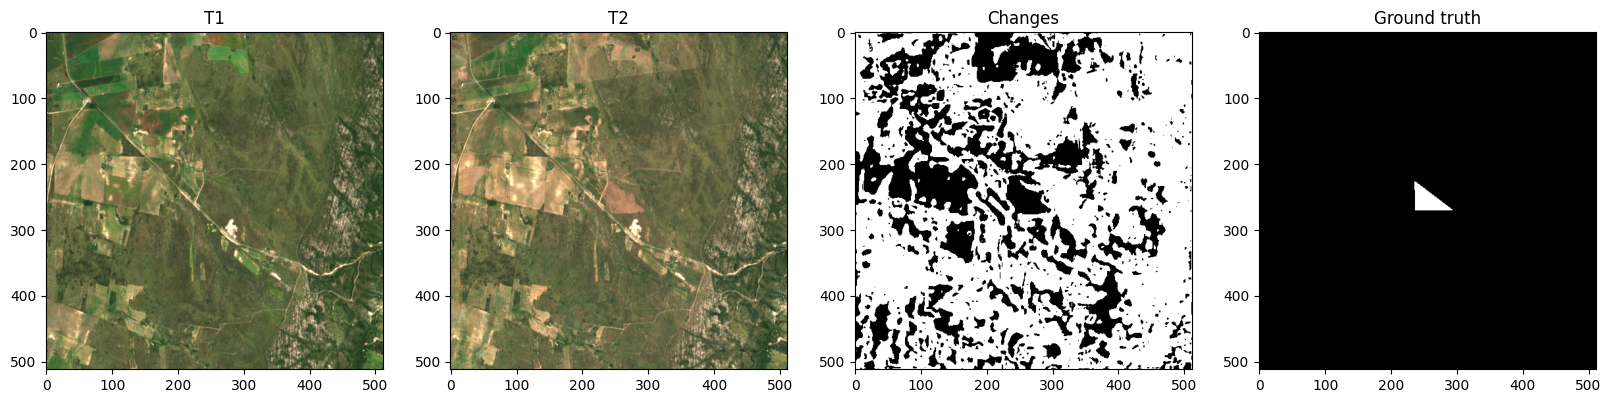

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0546..1.722].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0658..1.4532].


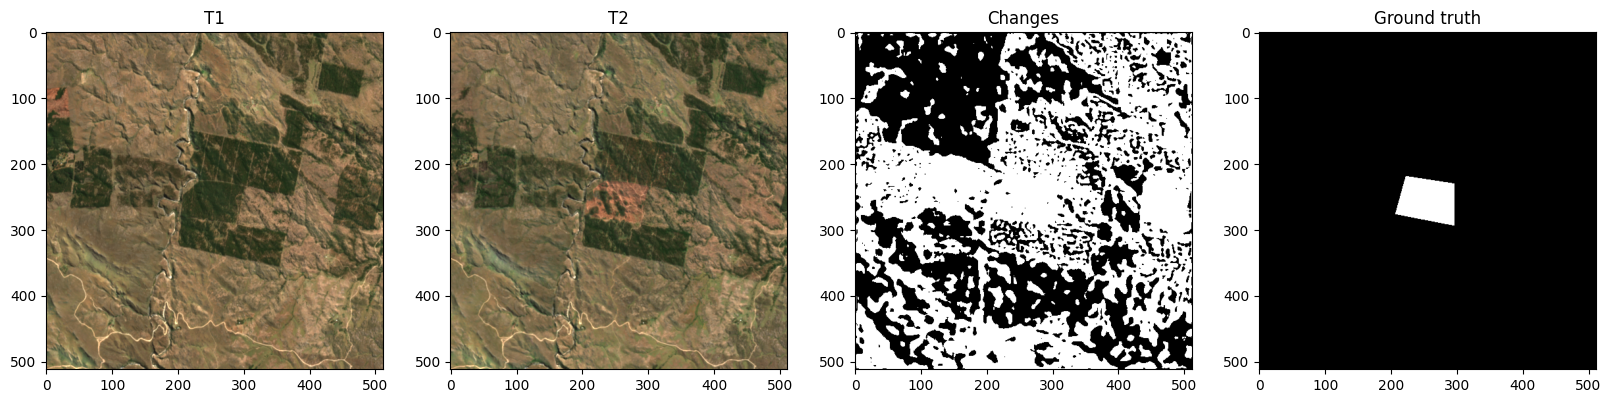

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1341..2.8968].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1767..2.4708].


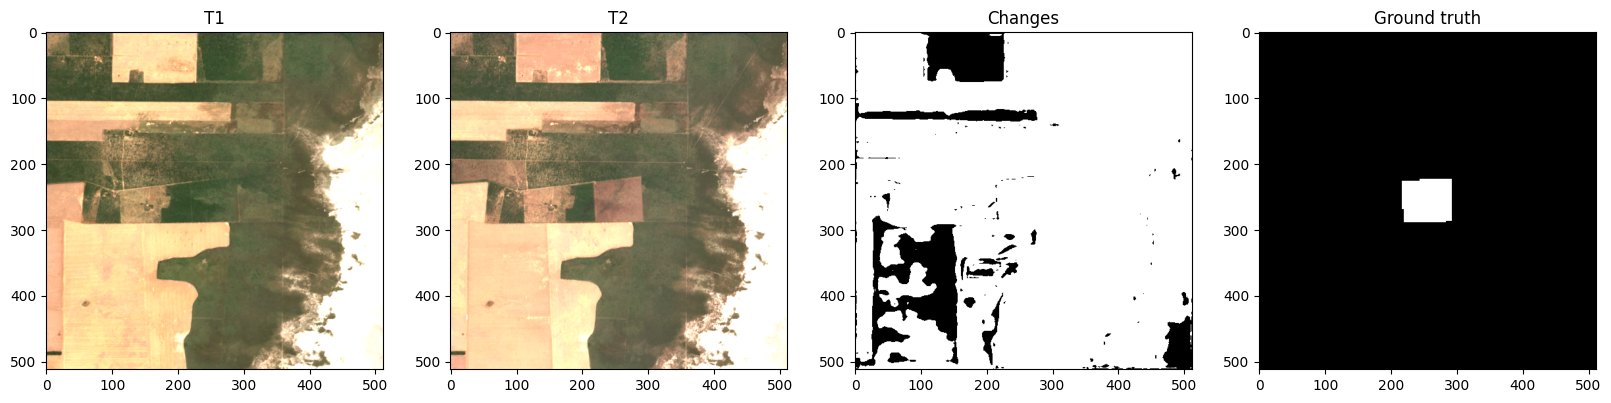

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1662..1.944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1464..1.9104].


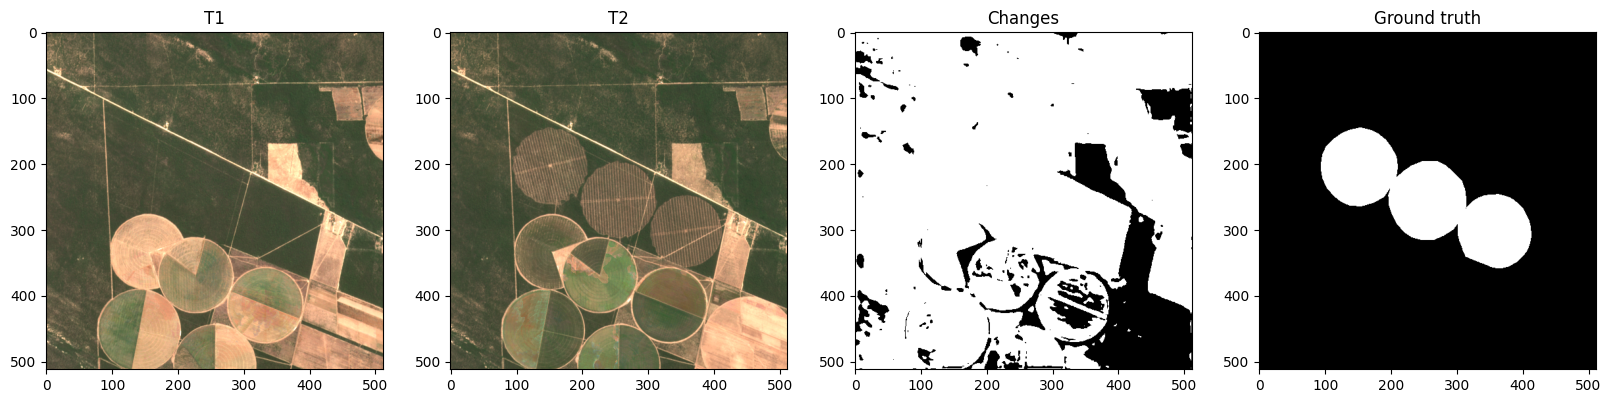

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1023..1.7826].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.108..1.6848].


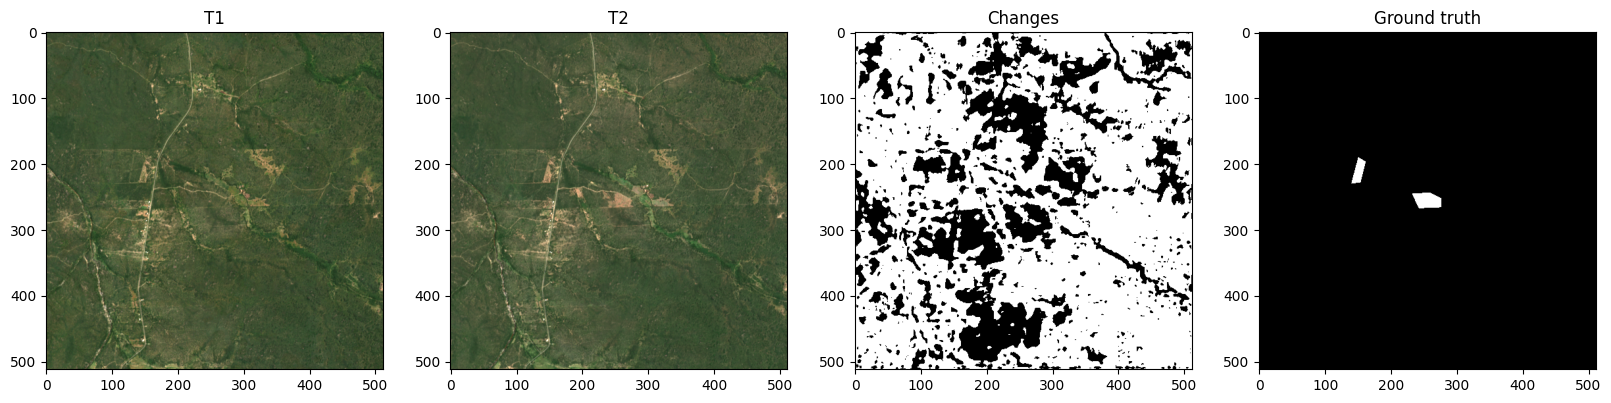

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.2026..1.764].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1858..1.5882].


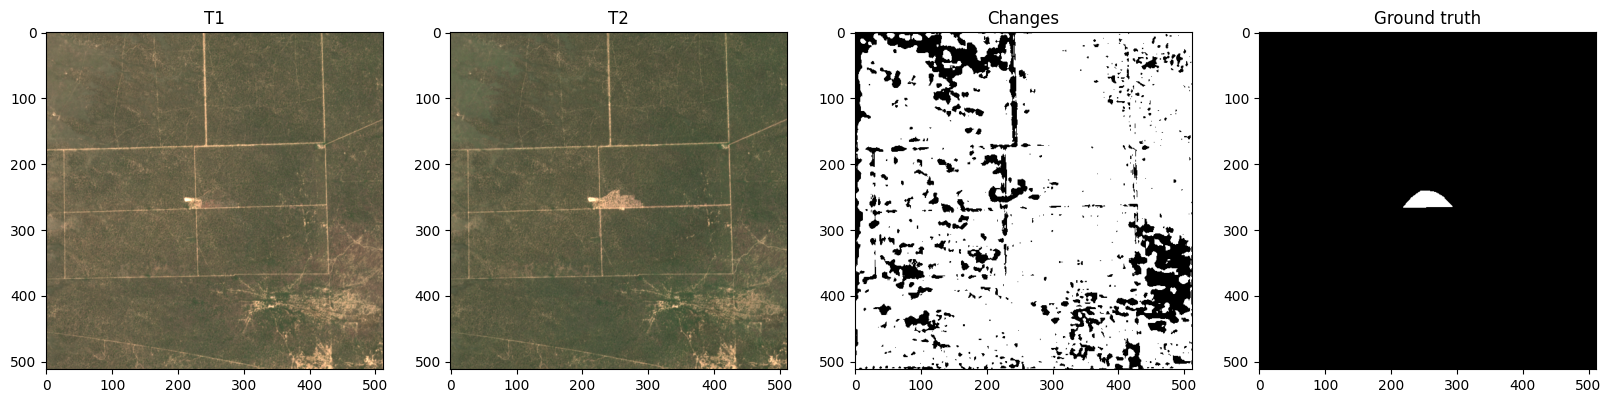

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.186..1.6368].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1992..1.6092].


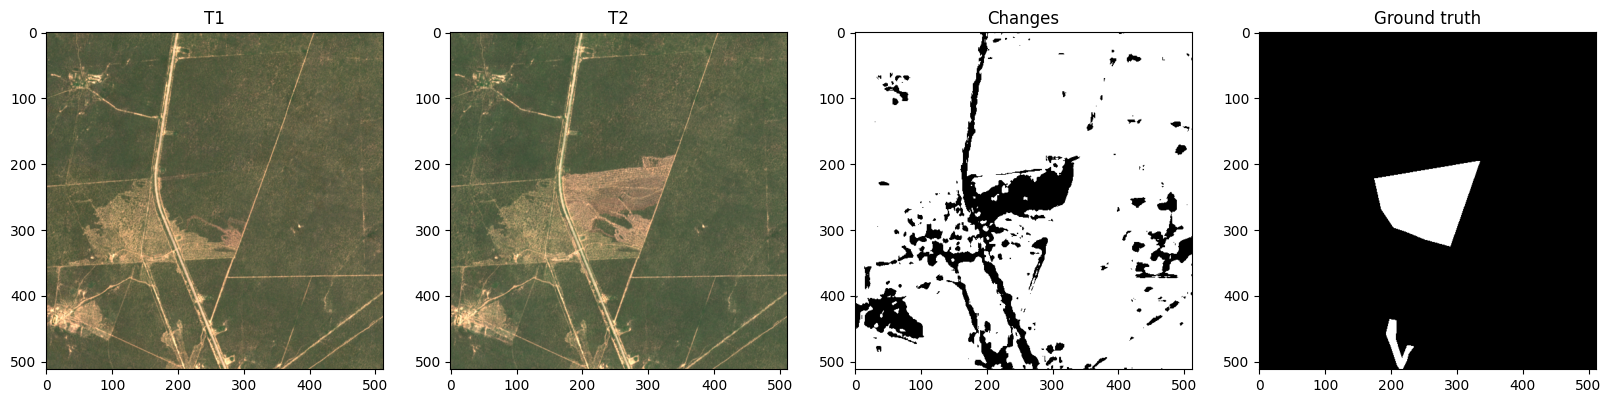

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1908..1.914].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1704..2.5632].


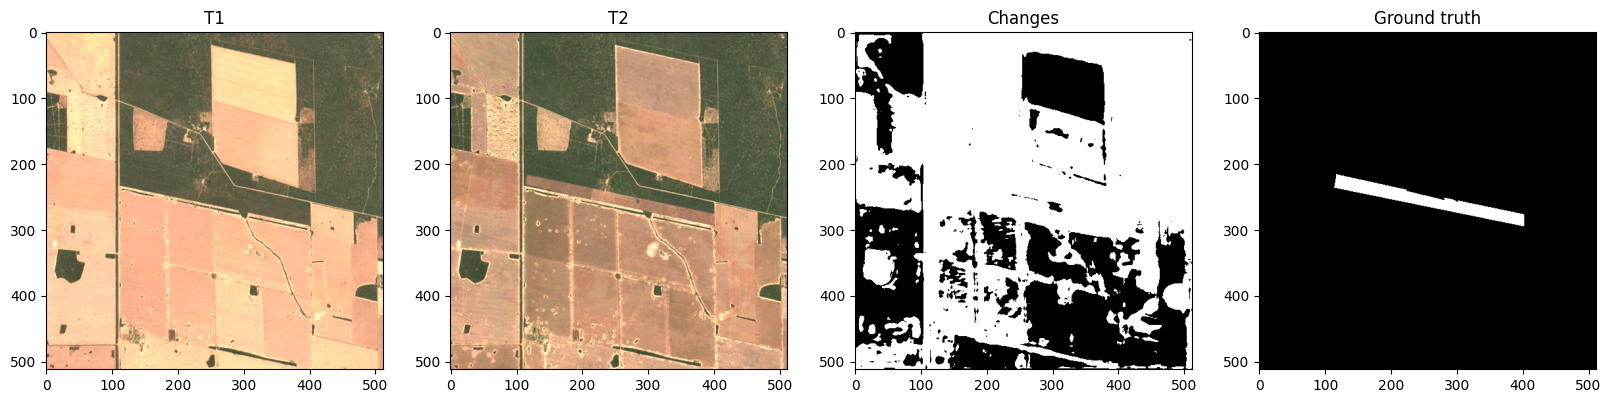

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13122857142857142..2.6352].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1206..2.2608].


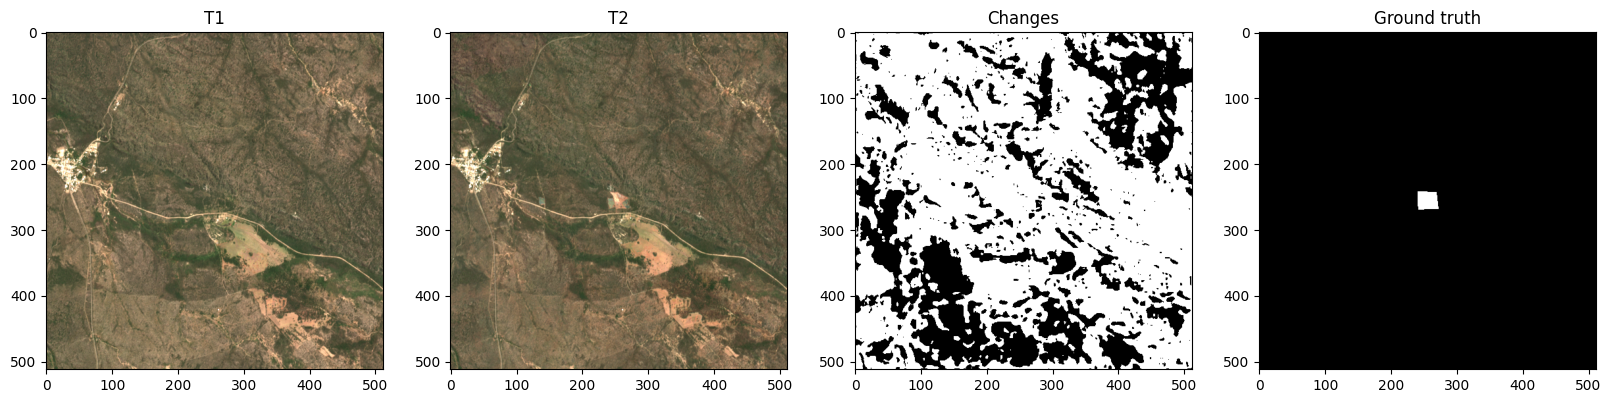

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.117..2.472].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1218..2.4144].


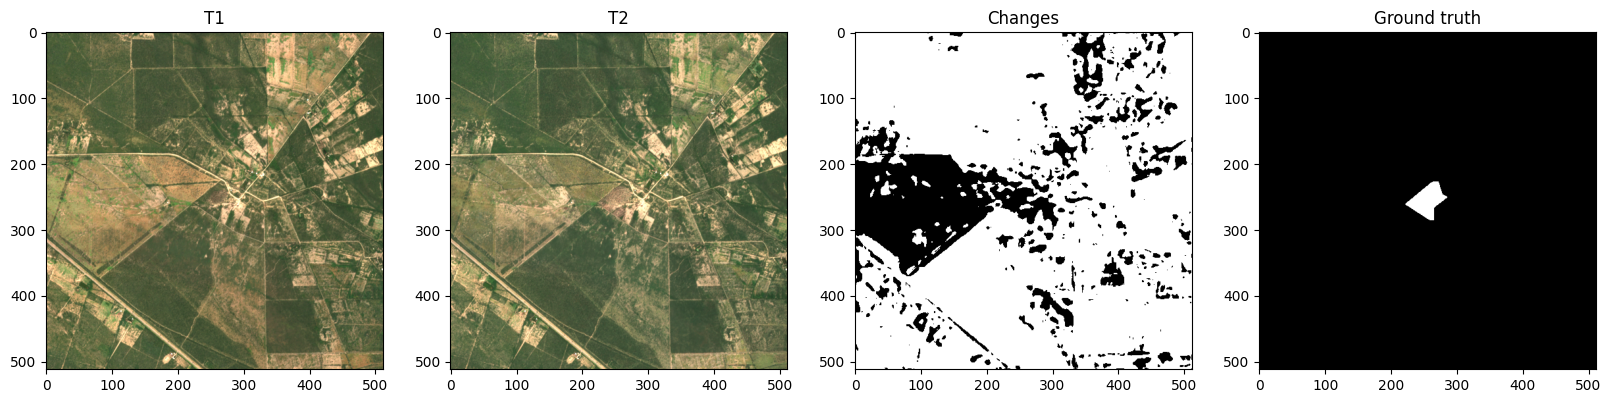

{'ROI': '0016', 'IoU': 0.0002453960965660906, 'F1': 0.0004906717841916455, 'Precision': 0.00024711018368523655, 'Recall': 0.03416856492027335, 'Kappa': -0.009580669683299181}
{'ROI': '0049', 'IoU': 0.03449912531698784, 'F1': 0.06669725371960411, 'Precision': 0.03451176167349486, 'Recall': 0.9894982497082847, 'Kappa': 0.029923412470553856}
{'ROI': '0073', 'IoU': 0.0213327594233962, 'F1': 0.041774356548476575, 'Precision': 0.0213327594233962, 'Recall': 1.0, 'Kappa': 0.005699158676144456}
{'ROI': '0101', 'IoU': 0.14502949268894186, 'F1': 0.25332009981395387, 'Precision': 0.14506086196184909, 'Recall': 0.9985111505321845, 'Kappa': 0.054483890294397375}
{'ROI': '0107', 'IoU': 0.003052711913471407, 'F1': 0.006086842450478814, 'Precision': 0.0030647291941875827, 'Recall': 0.4377358490566038, 'Kappa': -0.003991894684234776}
{'ROI': '0116', 'IoU': 0.004266833177229681, 'F1': 0.00849740932642487, 'Precision': 0.004274046611129744, 'Recall': 0.7165653495440729, 'Kappa': -0.0014982965190639685}
{'

In [3]:
# Set up the list to store the metrics
metrics_list = []

# Load the images paths
t1_files = sorted(list(pathlib.Path("./testData/t1").rglob("*.tif")))
t2_files = sorted(list(pathlib.Path("./testData/t2").rglob("*.tif")))
gt_files = sorted(list(pathlib.Path("./testData/gt").rglob("*.tif")))

# Iterate over the images
for i, (t1_file, t2_file, gt_file) in enumerate(zip(t1_files, t2_files, gt_files)):
    ## T1 and T2 input image
    with rasterio.open(t1_file) as src1, rasterio.open(t2_file) as src2, \
        rasterio.open(gt_file) as src3:
        t1 = src1.read() 
        t2 = src2.read() 
        gt_image = src3.read(1)

        # [B02, B03, B04, B05, B06, B07, B08, B8A, B11, B12]; NIR = B08/B8A, SWIR = B11; RED = B04
        # 1. NDMI calculation
        t1_ndmi = (t1[7] - t1[8]) / (t1[7] + t1[8])
        t2_ndmi = (t2[7] - t2[8]) / (t2[7] + t2[8])

        # 2. NDVI calculation
        t1_ndvi = (t1[6] - t1[2]) / (t1[6] + t1[2])
        t2_ndvi = (t2[6] - t2[2]) / (t2[6] + t2[2])

        # 3. Concatenate the bands (RED, GREEN, BLUE, NIR, SWIR1, SWIR2, NDVI, NDMI)
        t1 = t1[[0,1,2,6,7,8,9], :, :]
        t2 = t2[[0,1,2,6,7,8,9], :, :]

        ## Add NDVI and NDMI as last channels
        t1 = np.concatenate((t1, t1_ndvi[None], t1_ndmi[None]), axis=0)
        t2 = np.concatenate((t2, t2_ndvi[None], t2_ndmi[None]), axis=0)

        # Set the min and max values for the scaled image
        def image_scaling(input_band):
            min_value = 0
            max_value = 255

            input_band = np.nan_to_num(input_band)
            # Get the min and max values of the image
            min_input_band = max(input_band.min(), input_band.mean() - 2 * input_band.std())
            max_input_band = min(input_band.max(), input_band.mean() + 2 * input_band.std())

            # 3. Scale the image
            input_band_scaled = (input_band - min_input_band) * ((max_value - min_value) / (max_input_band - min_input_band)) + min_value
            input_band_scaled = np.clip(input_band_scaled, min_value, max_value)

            return input_band_scaled
        
        # 4. Scale the input images
        t1_scaled = [image_scaling(band) for band in t1]
        t2_scaled = [image_scaling(band) for band in t2]

        ## Merge the bands
        t1_scaled = np.stack(t1_scaled, axis=0)
        t2_scaled = np.stack(t2_scaled, axis=0)

    ## Load the model
    model = load_model("./weights/unet_diff.pth")
    model.eval()

    epsilon = 1e-10
    # Get the difference between the images
    t1_scaled = match_histograms(t1_scaled, t2_scaled, channel_axis=0)
    difference = (t2_scaled - t1_scaled) / (t1_scaled + t2_scaled + epsilon)
    difference = (difference + 1) * 127 

    # Concatenate the images
    input_patch = np.concatenate((difference.astype(np.uint8), 
                                t2_scaled.astype(np.uint8), 
                                t1_scaled.astype(np.uint8)), axis=0)

    # Modify the input tensor to have the correct shape
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_tensor = torch.from_numpy(input_patch).to(device, dtype=torch.float)

    # Predict the changes
    with torch.no_grad():
        predicted, _ = model.predict(image_tensor[None])
        predicted_np = predicted.detach().cpu().numpy().squeeze()
        binary_output = (predicted_np > 0.5).astype(np.uint8)

        # Calculate the metrics
        iou = jaccard_score(gt_image.flatten(), binary_output.flatten())
        f1 = f1_score(gt_image.flatten(), binary_output.flatten())
        precision = precision_score(gt_image.flatten(), binary_output.flatten())
        recall = recall_score(gt_image.flatten(), binary_output.flatten())
        kappa = cohen_kappa_score(gt_image.flatten(), binary_output.flatten())

        # Save the metrics in a list
        metrics_list.append({
            "ROI": t1_file.stem,
            "IoU": iou,
            "F1": f1,
            "Precision": precision,
            "Recall": recall,
            "Kappa": kappa
        })


    ## Plot the results
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow((t1[[2,1,0]]*6/ 10000).transpose(1, 2, 0))
    axs[0].set_title('T1')

    axs[1].imshow((t2[[2,1,0]]*6/ 10000).transpose(1, 2, 0))
    axs[1].set_title('T2')

    axs[2].imshow(binary_output, cmap='gray')
    axs[2].set_title('Changes')

    ## Ground truth
    axs[3].imshow(gt_image, cmap='gray')
    axs[3].set_title('Ground truth')

    plt.show() 

# Show the metrics
for metrics in metrics_list:
    print(metrics)

In [4]:
# Initialize the dictionary to store the sum of the metrics
sum_metrics = {'IoU': 0, 'F1': 0, 'Precision': 0, 'Recall': 0, 'Kappa': 0}

# Sum the metrics
for metrics in metrics_list:
    sum_metrics['IoU'] += metrics['IoU']
    sum_metrics['F1'] += metrics['F1']
    sum_metrics['Precision'] += metrics['Precision']
    sum_metrics['Recall'] += metrics['Recall']
    sum_metrics['Kappa'] += metrics['Kappa']

# Calculate the average of the metrics
num_metrics = len(metrics_list)
avg_metrics = {key: round(value / num_metrics, 3) for key, value in sum_metrics.items()}

# Show the average of the metrics
print("Average metrics:")
for key, value in avg_metrics.items():
    print(f"{key}: {value}")

Average metrics:
IoU: 0.027
F1: 0.049
Precision: 0.027
Recall: 0.674
Kappa: 0.002


### Bibliography

```
@ARTICLE{9241044,
  author={Isaienkov, Kostiantyn and Yushchuk, Mykhailo and Khramtsov, Vladyslav and Seliverstov, Oleg},
  journal={IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing}, 
  title={Deep Learning for Regular Change Detection in Ukrainian Forest Ecosystem With Sentinel-2}, 
  year={2021},
  volume={14},
  number={},
  pages={364-376},
  keywords={Forestry;Remote sensing;Vegetation mapping;Labeling;Deep learning;Earth;Image segmentation;Change detection;convolutional neural network (CNN);deep learning;deforestation;logging;LSTM;optical imagery;semantic segmentation;U-Net},
  doi={10.1109/JSTARS.2020.3034186}}
```